<H1 style="text-align: center">ECMM422 - Machine Learning</H1>
<H2 style="text-align: center">Assignment 4: Reinforcement Learning</H2>

| Date set     | Hand-in date |
|:------------------|:-----------------------------------|
| 6th March 2020  | **  Wednesday 18th March ** |


This workshop is worth 25% of the total module mark.





Your report should consist of your IPython notebook showing what you did, what was the
result, and what you can conclude from the exercise. Each report will be
assessed on the following criteria:

* Does it record what was done in the exercise?
* Does it permit the results to be reproduced?
* How does the work relate to the theoretical foundations discussed in lectures?
* Is it well presented?

### Submitting the notebooks

Note that an electronic submission is required.  You should also submit the notebook electronically at [electronic hand-in system]( http://empslocal.ex.ac.uk/submit/).  You just need to submit the single .ipynb file that is the notebook, so you should be able to upload it directly from the directory where you have saved it on a University machine or your laptop.  If you're not sure where in your homespace it is, type <code>pwd</code> (print working directory) in a cell to find out where the notebooks are.

<b>Note: you must also submit your cover sheet and E-Submit receipt via BART to complete the submission.</b>


<div class="alert alert-info">
Although you will undoubtedly work collaboratively in the workshops themselves, these are *individual* exercises.  The reports you write should be about the results *you* obtained, and your attention is drawn to the College and University guidelines on collaboration and plagiarism. 
</div>


In [0]:
# including libraries as usual
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors


# Gridworld example

The following code will provide you with a working gridworld problem. You are asked to study the code and use it to provide a solution in the following questions. 

`Note: Edits made to the Gridworld class are marked with horizontal bars`

In [2]:
from matplotlib.colors import ListedColormap

class GridWorld: 
    '''
    Class implementing a typical GridWorld problem. 
    
    '''
    
    
    def __init__(self, width, height, gamma=1, penalty=-1, start=[0,0], goal=[0,0], cliff=[], cliff_penalty=-10):
        '''
        Generates a new Gridworld problem, with a grid of size (width,height). 
        gamma: reward discoount parameter (default:1)
        penalty: penalty for each move (default:-1)
        start: start location (default: [0,0])
        goal: goal location (default: [0,0])
        cliff: list of locations defined as cliff (the agent incurs a large
               penalty for walking into cliffs and is transported back to the
               start). 
        cliff_penalty: penalty incurred for walking into a cliff (default: -100). 
        '''
        # define the four possible actions
        self.gamma = gamma
        self.actions = range(4)
        self.delta = np.array([[0,-1],[+1,0],[0,+1],[-1,0]])
        self.action_labels = ['up','right','down','left']
        
        self.states = range(width*height)

        self.width = width
        self.height = height
        
        # set the start state
        self.start = self.encode_state(start)     

        self.cliff = [self.encode_state(s) for s in cliff]
        
        ########################################################################
        '''
        Changes made to the goal variable to allow for multiple goals. By
        reshaping the array, allows for a single goal to be inputted in the same
        way as was before.

        The change essentially matches what was used for cliffs originally.
        '''

        goal = np.array(goal).reshape(-1,2).tolist()
        
        self.goal = [self.encode_state(g) for g in goal]           

        self.penalty = penalty
        self.cliff_penalty = cliff_penalty

        self.grid = np.zeros((height,width))
        
        for c in range(width): 
            for r in range(height): 
                if [c,r] in goal: 
                    self.grid[r,c] = 1
                elif [c,r] in cliff: 
                    self.grid[r,c] = 2
                elif [c,r] == start: 
                    self.grid[r,c] = 3
        ########################################################################
        
    def line_string(self):
        s = '+'
        for j in range(self.width):
            s += '-+'
        s += '\n'
        return s
    
        
    def tostring(self): 
        '''
            Converts the grid world to a formatted string. 
        '''
        s = 'Grid world:\n'
        for r in range(self.height): 
            s += self.line_string()
            s += '|'
            for c in range(self.width):                 
                if self.grid[r,c] == 1: 
                    s += 'G'
                elif self.grid[r,c] == 2: 
                    s += 'X'
                elif self.grid[r,c] == 3:
                    s += 'S'
                else: 
                    s += ' '
                s += '|'
            s += '\n'
            
        s += self.line_string()
        return s    
    
    
    
    def print_solution(self,S): 
        '''
        Graphical display of a solution S, given as a list of states that brings from the initial state to the goal. 
        '''
        s = 'Solution:\n'
        for r in range(self.height): 
            s += self.line_string()
            s += '|'
            for c in range(self.width):                 
                p = self.encode_state((c,r))                
                
                if self.grid[r,c] == 1: 
                    s += 'G'
                elif self.grid[r,c] == 3:
                    s += 'S'
                elif p in S:
                    if p == S[-1]:
                        s += '@'
                    else:
                        s += '*'
                elif self.grid[r,c] == 2: 
                    s += 'X'
                else: 
                    s += ' '
                s += '|'
            s += '\n'
            
        s += self.line_string()
        return s 
    

    def get_start(self):
        '''
        Returns state pointer of the starting point
        '''
        flat_grid = np.array(self.grid).flatten()
        mask = ([i  for i in range(len(flat_grid)) if flat_grid[i] == 3])
        return mask[0]
    

    def get_goals(self):
        '''
        Returns state pointer of the starting point
        '''
        flat_grid = np.array(self.grid).flatten()
        mask = ([i  for i in range(len(flat_grid)) if flat_grid[i] == 1])
        return mask
        
    ############################################################################
    def plot_grid(self):
        '''
        Display grid as a plot, green is start, red is goal, and gray is cliff.
        '''
        plt.figure(figsize=(self.width, self.height))
        plt.xticks(np.arange(0, self.width, 1))
        plt.yticks(np.arange(0, self.height, 1))
        cmap = ListedColormap(['lavender','red','dimgray','forestgreen'])

        '''
        The grid is flipped as the matplotlib heatmap function plots bottom to
        top rather than top to bottom as the grid is defined.
        '''
        heatmap = plt.pcolor(np.flip(np.array(self.grid),0), cmap=cmap)
        plt.grid()
    ############################################################################

    def plot_states(self):
        '''
        Display grid as a plot in the same was as `plot_grid(self)` with
        additonal text showing state label on top of the colour.
        '''
        plt.figure(figsize=(self.width, self.height))
        plt.xticks(np.arange(0, self.width, 1))
        plt.yticks(np.arange(0, self.height, 1))
        plt.title("States of Gridworld")
        cmap = ListedColormap(['lavender','red','dimgray','forestgreen'])

        heatmap = plt.pcolor(np.flip(np.array(self.grid),0), cmap=cmap)
        plt.grid()
        
        state = np.array(self.states).reshape(self.width, self.height)
        
        for i in range(self.width):
            for j in range(self.height):
                text = plt.text(i + 0.5, self.height - (j + 0.5), state[i,j],
                       ha="center", va="center", color="k")
    ############################################################################            
                
    def plot_solution(self, path, title = "Solution found for Gridworld"):
        '''
        Display grid as a plot with states shown as text with the solution/path
        found by an algorithm marked as yellow squares. In the case that the
        algorithm fails to find the goal, the end of the path is marked in
        orange, denoting where is got stuck.
        '''
        plt.figure(figsize=(self.width, self.height))
        plt.xticks(np.arange(0, self.width, 1))
        plt.yticks(np.arange(0, self.height, 1))
        plt.title(title)
        
        cmap = ListedColormap(['lavender','red','dimgray','forestgreen', 'yellow'])
        #bounds=[-0.5, 0.5, 1.5, 2.5, 3.5]
        #norm = colors.BoundaryNorm(bounds, cmap.N)
        
        
        grid = self.grid

        for s in path[:-1]:
            s = int(s)
            if grid[s % self.height][s//self.height] == 0:
                grid[s % self.height][s//self.height] = 4
        
        s = int(path[-1])
        if grid[s % self.height][s//self.height] == 0:
            grid[s % self.height][s//self.height] = 5
            cmap = ListedColormap(['lavender','red','dimgray','forestgreen', 'yellow', 'orange'])
                
        grid = np.flip(grid.reshape(self.height, self.width),0)        
        
        heatmap = plt.pcolor(grid, cmap=cmap)
        #plt.colorbar(heatmap, ticks=["", "Goal", "Cliff", "Start"])
        plt.grid()
        
        state = np.array(self.states).reshape(self.width, self.height)
        
        for i in range(self.width):
            for j in range(self.height):
                text = plt.text(i + 0.5, self.height - (j + 0.5), state[i,j],
                       ha="center", va="center", color="k")
                
        
    def plot_value_function(self, V = None, title = ""):
        '''
        Display grid as a plot with value function shown above
        '''
        try:
            if not V:
                return False
        except:
            if not len(V) == len(self.states):
                return False
        
        plt.figure(figsize=(self.width, self.height + 0.1))
        plt.xticks(np.arange(0, self.width, 1))
        plt.yticks(np.arange(0, self.height, 1))
        plt.title(title)
        cmap = ListedColormap(['lavender','red','dimgrey','forestgreen'])
        #bounds=[-0.5, 0.5, 1.5, 2.5, 3.5]
        #norm = colors.BoundaryNorm(bounds, cmap.N)
        heatmap = plt.pcolor(np.flip(np.array(self.grid),0), cmap=cmap)
        #plt.colorbar(heatmap, ticks=[0, 1, 2, 3])
        plt.grid()
        
        V = np.round(np.array(V).reshape(self.width,self.height),decimals=2)
        
        for i in range(self.width):
            for j in range(self.height):
                text = plt.text(i + 0.5, self.height - (j + 0.5),
                                round(V[i,j],2), ha="center", va="center",
                                color="k")
 
 
    def plot_Q_options(self, Q = None, title = ""):
        '''
        Display grid as a plot with Q-value option shown above. i.e. What move
        would be taken at this point by the algorithm if using a greedy strategy.
        '''
        try:
            if not Q:
                return False
        except:
            if not (len(Q) == len(self.states)):
                print(Q.shape)
                print(len(Q))
                print(len(self.states))
                return False
        
        plt.figure(figsize=(self.width, self.height + 0.1))
        plt.xticks(np.arange(0, self.width, 1))
        plt.yticks(np.arange(0, self.height, 1))
        plt.title(title)
        cmap = ListedColormap(['lavender','red','dimgrey','forestgreen'])
        #bounds=[-0.5, 0.5, 1.5, 2.5, 3.5]
        #norm = colors.BoundaryNorm(bounds, cmap.N)
        heatmap = plt.pcolor(np.flip(np.array(self.grid),0), cmap=cmap)
        #plt.colorbar(heatmap, ticks=[0, 1, 2, 3])
        plt.grid()
        
        Q = np.round(np.array(Q).reshape(self.width,self.height,len(self.actions)),decimals=4)
        
        for i in range(self.width):
            for j in range(self.height):
                text = plt.text(i + 0.5, self.height - (j + 0.5), self.action_labels[np.argmax(Q[i,j,:])], ha="center", va="center", color="k")
    
    
    def plot_Q_function(self, Q = None, title = "", Path = None):
        '''
        Display grid as a plot with Q-value function shown above as arrows
        '''
        try:
            if not Q:
                return False
        except:
            if not (len(Q) == len(self.states)):
                print(Q.shape)
                print(len(Q))
                print(len(self.states))
                return False
        
        plt.figure(figsize=(self.width, self.height + 0.1))
        plt.xticks(np.arange(0, self.width, 1))
        plt.yticks(np.arange(0, self.height, 1))
        plt.title(title)
        if Path == None:
            cmap = ListedColormap(['lavender','red','dimgray','forestgreen'])
            heatmap = plt.pcolor(np.flip(np.array(self.grid),0), cmap=cmap)
        else:
            cmap = ListedColormap(['lavender','red','dimgray','forestgreen', 'yellow'])
            #bounds=[-0.5, 0.5, 1.5, 2.5, 3.5]
            #norm = colors.BoundaryNorm(bounds, cmap.N)


            grid = self.grid


            for s in path[:-1]:              
                if grid[s % self.height][s//self.height] == 0:
                    grid[s % self.height][s//self.height] = 4

            s = path[-1]
            if grid[s % self.height][s//self.height] == 0:
                grid[s % self.height][s//self.height] = 5
                cmap = ListedColormap(['lavender','red','dimgray','forestgreen', 'yellow', 'orange'])
            grid = np.flip(grid,0)
            heatmap = plt.pcolor(grid, cmap=cmap)
        #plt.colorbar(heatmap, ticks=[0, 1, 2, 3])
        plt.grid()
        
        Q = np.round(np.array(Q).reshape(self.width,self.height,len(self.actions)),decimals=4)
        
        for i in range(self.width):
            for j in range(self.height):                
                dQ = Q[i,j,:] - min(Q[i,j,:])
                #print(dQ)
                mQ = max(dQ)
                plt.arrow(i + 0.5, self.height - (j + 0.5), (0.5 * (dQ[1] - dQ[3]) / mQ), (0.5 * (dQ[0] - dQ[2]) / mQ), fc='k', ec='k')
    ############################################################################
    
    def show_states(self):
        '''
        Displays state IDs on a grid. 
        '''
        print( np.array(self.states).reshape((self.width,self.height)).T )
    
    def encode_state(self,coord):
        '''
        Converts a tuple (c,r) containing grid coordinates to the corresponding (scalar) state ID. 
        '''
        (c,r) = coord
        if r<self.height and c<self.width and r>=0 and c>=0: 
            return int(c*self.height+r)
        else: 
            return -1
    
    def decode_state(self,s): 
        '''
        Converts a state ID into grid coordinates. 
        '''
        return (s//self.height,s%self.height)
        
    def state_action_state(self,s,a): 
        '''
        Generates the next state and associated reward for a state/action pair. 
        '''
        
        ns = self.encode_state(self.decode_state(s) + self.delta[a,:])
        
        if ns in self.cliff: 
            return [(self.start, self.cliff_penalty)]
        
        # if an invalid state is generated, stay where we are
        elif ns < 0: 
            return [(s,self.penalty)]
        
        # if the goal is reached, no penalty incurred. 
        elif ns == self.goal: 
            return [(ns,0)]
        
        else: 
            return [(ns,self.penalty)]
        
    def state_transition(self,s): 
        '''
        Generates lists of all possible action/next state/reward triplets for the current state. 
        Returns a triplet of lists (sv,pv,rv), with one element per action, where: 
        sv[a] is the next state following the action a.
        pv[a] is the likelihood to select action a (policy). 
        rv[a] is the immediate reward of selecting action a. 
        '''
        
        sv = np.zeros(len(self.actions),dtype='uint')
        pv = np.zeros(len(self.actions))
        rv = np.zeros(len(self.actions))
        
        for a in self.actions: 
            (s2,r2) = self.state_action_state(s,a)[0]
            sv[a] = s2
            pv[a] = 1.0/len(self.actions)
            rv[a] = r2
            
        return (sv,rv,pv)
            
world = GridWorld(6,4, gamma=0.9, goal=[[5,3]], start=[0,3], cliff=[[1,3],[2,3],[3,3],[4,3]])
print( world.tostring() )

world.show_states()

print('GridWorld state indexing:')
print(world.grid)

Grid world:
+-+-+-+-+-+-+
| | | | | | |
+-+-+-+-+-+-+
| | | | | | |
+-+-+-+-+-+-+
| | | | | | |
+-+-+-+-+-+-+
|S|X|X|X|X|G|
+-+-+-+-+-+-+

[[ 0  4  8 12 16 20]
 [ 1  5  9 13 17 21]
 [ 2  6 10 14 18 22]
 [ 3  7 11 15 19 23]]
GridWorld state indexing:
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [3. 2. 2. 2. 2. 1.]]


## 1. Policy evaluation

One simple way to solve a reinforcement learning problem is to estimate the value function for the whole problem and then apply a greedy strategy to find the goal. In the first part you are asked to evaluate the value function V(s) for all states (ie, grid cells), using <b>policy iteration</b>, as discussed in class. 
Iterative policy evaluation proposes an update of the value function based on the recursive formulation of the <i>Bellman equation</i>: 

$$
V^{(t+1)}(S_t) \leftarrow \sum_{S_{t+1},R_{t+1}} p\left[S_{t+1},R_{t+1}|S_t,\pi(S_t)\right] \left(R_{t+1}+\gamma V^{t}(S_{t+1})\right)
$$

In this part, you will:

a. Estimate the value of V(s) using policy iteration. Each step of policy iteration will take as parameter the problem to be solved (which will provide the required functions) and the current estimate of the value function (as an array with length equal to the grid size). 
<div style="text-align: right"><b>[10 marks]</b></div>

b. Print out the estimated value function after 1,2,5 and 10 iterations. 
<div style="text-align: right"><b>[10 marks]</b></div>

c. Provide a solution using a greedy strategy and the estimated value function. Print it out using the print_solution() method. 
<div style="text-align: right"><b>[10 marks]</b></div>

[[ 0  5 10 15 20]
 [ 1  6 11 16 21]
 [ 2  7 12 17 22]
 [ 3  8 13 18 23]
 [ 4  9 14 19 24]]


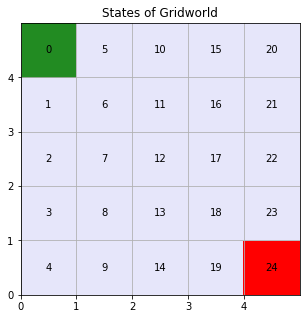

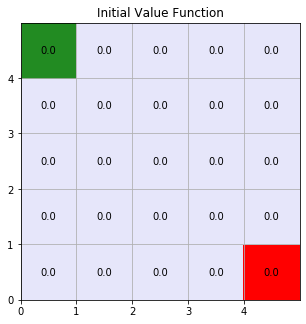

In [3]:
world = GridWorld(5,5, gamma=0.9, start=[0,0], goal=[4,4])
np.set_printoptions(precision=2)

world.show_states()
#world.plot_grid()
world.plot_states()

V = np.zeros(len(world.states))
#print(V.reshape((world.width,world.height)).T)
world.plot_value_function(V = V, title = "Initial Value Function")

### 1.a/b:
For this part I am required to define the functions to find the value of V(S) from the policy iteration function from the Bellman's equation. In the course literature, the psuedo code for this as an iterative formula is given. After this an example is covered where it goes through the calculation of a policy. For testing, this is the grid that will be used.

*Note: Edits made to GridWorld function made to allow for multiple goals*

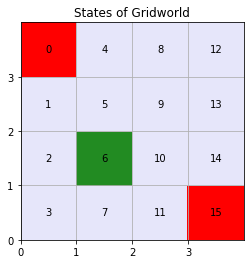

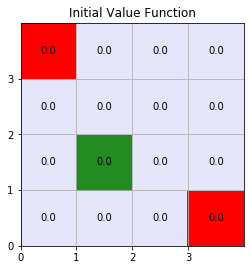

In [4]:
test_world = GridWorld(4,4, gamma=1.0, start=[1,2], goal=[[3,3],[0,0]])
np.set_printoptions(precision=2)

#world.show_states()
#world.plot_grid()
test_world.plot_states()

V = np.zeros(len(test_world.states))
#print(V.reshape((world.width,world.height)).T)
test_world.plot_value_function(V = V, title = "Initial Value Function")

The psuedo-code for the iterative policy evaluation is as follows:

\begin{align*}
\textbf{Input: } \pi& \text{,  policy to be evaluated.} \\ \\
\text{Initialize}&  \text{ an array} V(S) = 0,\forall{s} \in S   \\
\textbf{repeat:}& \\
&\Delta  \leftarrow 0 \\
&\textbf{for } s \in S \textbf{ do} \\
&\qquad v \leftarrow V(s) \\
&\qquad V(s) \leftarrow \sum_{s', r} p[s', r\mid s, \pi(s)](r + \gamma V(s')) \\
&\qquad \Delta \leftarrow max(\delta, \mid v - V(s) \mid) \\
\textbf{until: }& \Delta < \epsilon \\
\textbf{return }& V
\end{align*}

This is defined for this project below.

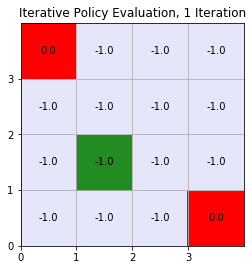

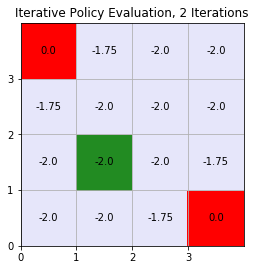

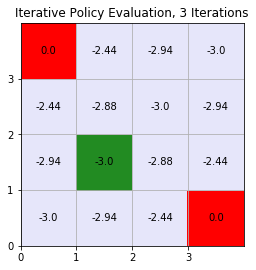

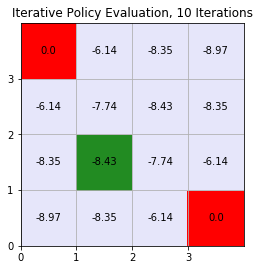

In [5]:
def iterative_policy_evaluation(world, ite = 1):
    V = np.zeros(len(world.states))
    g = np.array(world.grid).T.flatten()
    states = [s for s in world.states if (not g[s] == 1.0)]
    for i in range(ite):
        delta = 0
        Vdash = np.zeros(len(world.states))
        for s in states:
            v = V[s]
            #print(f"State: {s}, \n\t transitions: {world.state_transition(s)}")
            sv, rv, pv = world.state_transition(s)
            nV = 0
            for dash in range(len(sv)):
                nV += pv[dash] * (rv[dash] + (world.gamma * V[sv[dash]]))
            Vdash[s] = nV
        V = Vdash
    return V

'''
Using "test" world from the literature
'''

V = iterative_policy_evaluation(test_world)
test_world.plot_value_function(V = V, title = "Iterative Policy Evaluation, 1 Iteration")

V = iterative_policy_evaluation(test_world, ite = 2)
test_world.plot_value_function(V = V, title = "Iterative Policy Evaluation, 2 Iterations")

V = iterative_policy_evaluation(test_world, ite = 3)
test_world.plot_value_function(V = V, title = "Iterative Policy Evaluation, 3 Iterations")

V = iterative_policy_evaluation(test_world, ite = 10)
test_world.plot_value_function(V = V, title = "Iterative Policy Evaluation, 10 Iterations")

Above the test world results closely resemble those seen in the literature with slight differences due to rounding. From this we can assume that the function works as expected. From here on the world asked for in the question is used.

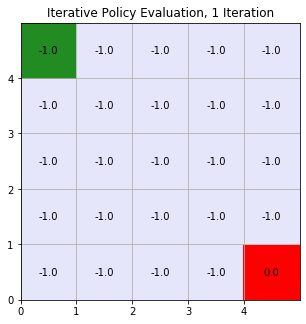

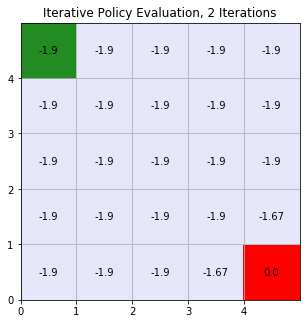

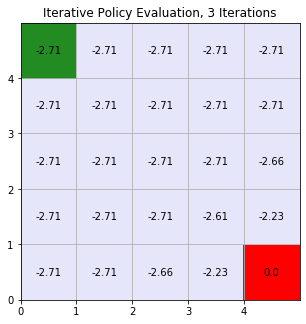

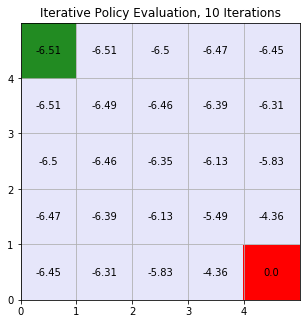

In [6]:
world = GridWorld(5,5, gamma=0.9, start=[0,0], goal=[4,4])

V = iterative_policy_evaluation(world)
world.plot_value_function(V = V, title = "Iterative Policy Evaluation, 1 Iteration")

V = iterative_policy_evaluation(world, ite = 2)
world.plot_value_function(V = V, title = "Iterative Policy Evaluation, 2 Iterations")

V = iterative_policy_evaluation(world, ite = 3)
world.plot_value_function(V = V, title = "Iterative Policy Evaluation, 3 Iterations")

V = iterative_policy_evaluation(world, ite = 10)
world.plot_value_function(V = V, title = "Iterative Policy Evaluation, 10 Iterations")

Above is the value function required for parts `a` and `b` are above.


### 1.c.

For the final part of this question, we are required to implement a greedy strategy to find the optimal path and print it. For the greedy startegy, starting from the starting point, the best out of the possible actions is taken each time. For the case where the expected values are equal, a random one is chosen. From this "greediness" the strategy can get stuck if no possible move is considered "better". This occurs when cliffs are included, more on this later.

I had issues with the `print_solution` function and as such I implemented a "`plot_solution`" function which displays the path found in yellow, with the end of the path marked in orange (if algorithm gets stuck). The issue came from confusion between how the grid functioned for `GridWorld` and I only figured out later that in the initialisation everything is translated for some reason. As such my version ended up highly edited, however the end product is the same (with different visuals).

Solution: [0, 5, 6, 11, 12, 17, 18, 23, 24]


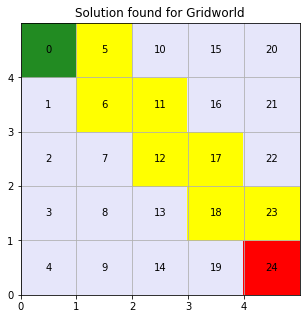

In [7]:
def greedy(world, V):
    start = world.start
    goals = world.goal
    pos = start
    path = [pos]
    while (not pos in goals):
        sv, _, _ = world.state_transition(pos)
        values = [V[s] for s in sv]
        
        olpos = pos
        pos = sv[np.argmax(values)]
        
        if pos in path:
            break
            
        path.append(pos)
    return path

world = GridWorld(5,5, gamma=0.9, start=[0,0], goal=[4,4])
V = iterative_policy_evaluation(world, ite = 10)
sol = greedy(world, V)

print(f"Solution: {sol}")
world.print_solution(sol)
world.plot_solution(sol)

For further experimentation, below is a version of grid world problem where some cliffs have been introduced. As you can see, if the previous value used for $\gamma$ is reused in the iterative policy function, the greedy startegy becomes stuck after a short while. This is due to each of the possible actions for it to take being worse that the current choice. In this example, the top corner where it ends has a value of $-10.18$, however the only move possible, downwards, has a worse value and it halts. Even if the function is run for many more iterations, this remains as it has converged. However, if the value of gamma is increased above $1$, allowing for the function to diverge we get an evaluation of the grid where the greedy strategy function finds the end. However it still does not find the optimal solution. It can be said rather than finding the optimal solution, when cliffs are involved, the greedy strategy finds the "safe" path.

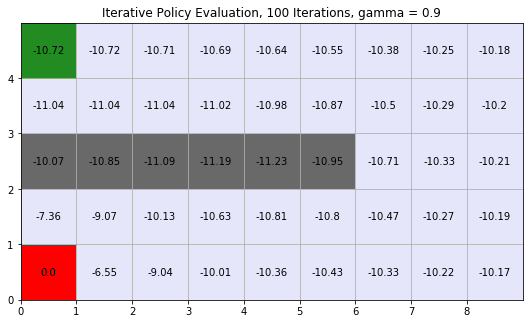

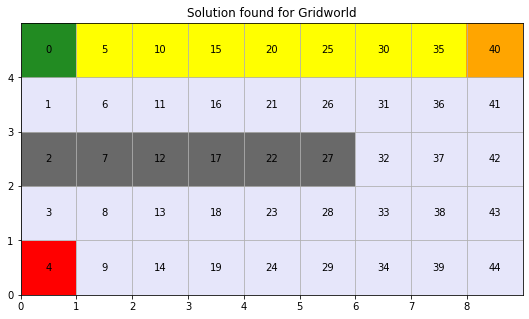

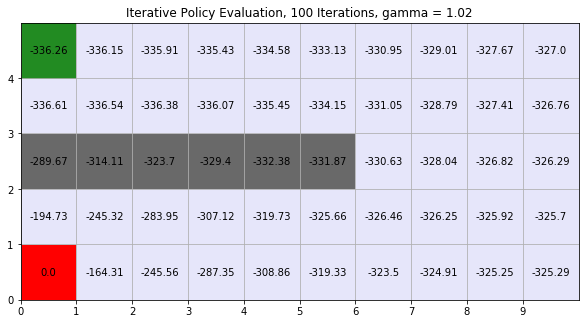

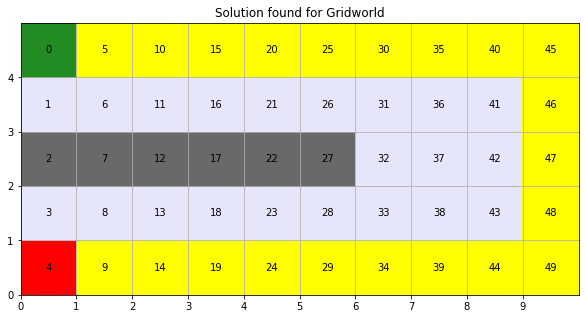

In [8]:
world3 = GridWorld(9,5, gamma=0.9, start=[0,0], goal=[0,4], cliff=[[0,2], [1,2], [2,2], [3,2], [4,2], [5,2]],cliff_penalty=-2)

V = iterative_policy_evaluation(world3, ite = 100)
sol = greedy(world3, V)

world3.plot_value_function(V = V, title = "Iterative Policy Evaluation, 100 Iterations, gamma = 0.9")
world3.plot_solution(sol)


world3 = GridWorld(10,5, gamma=1.02, start=[0,0], goal=[0,4], cliff=[[0,2], [1,2], [2,2], [3,2], [4,2], [5,2]],cliff_penalty=-2)

V = iterative_policy_evaluation(world3, ite = 100)
sol = greedy(world3, V)

world3.plot_value_function(V = V, title = "Iterative Policy Evaluation, 100 Iterations, gamma = 1.02")
world3.plot_solution(sol)

## 2. State-Action-Reward-State-Action (SARSA)
Value iteration requires a complete knowledge of the problem and its dynamics (ie, the capacity to simulate any state). In any practical problem this is not the case. Consider a robot operating: It is limited to learning from the actual experiences it encounters, and can only speculate on what could have been. 

SARSA is a reinforcement algorithms that reformulates the Temporal Difference (TD) rule seen before to allow the learning of a value function for state-action pairs (ie, the value of an action in a given state) from limited experiences only.  
In SARSA, the state-action value function $Q^{(t)}(S_t,A_t)$ is learnt by updating: 
$$
		Q^{(t+1)}(S_t, A_t) \leftarrow Q^{(t)}(S_t,A_t) + \alpha \left[R_{t+1} + \gamma Q^{(t)}(S_{t+1},A_{t+1}) - Q^{(t)}(S_t,A_t)\right]   
$$

In this part, you will:

a. Implement the SARSA algorithm, using an $\epsilon$-greedy policy. 
<div style="text-align: right"><b>[10 marks]</b></div>
b. Produce a graph showing the performance of the agent in y-axis and the number of episodes in x-axis. 
<div style="text-align: right"><b>[10 marks]</b></div>
c. Finally, show the solution your algorithm has reached for different values of $\epsilon$.
<div style="text-align: right"><b>[10 marks]</b></div>


### 2.a.

#### Temporal Difference Learning

As discussed above, the issue with the previous implementation and other examples of Dynamic Programming is that it requires complete knowledge of the problem. Another approach is using temporal difference based methods. Temporal difference algorithms enable the system to learn about the problem through every action it takes. The knowledge is updated on each timestep rather than when it finds the goal or can no longer continue (episode).

#### SARSA

Psuedo-code for SARSA from the literature is below:

\begin{align*}
\textbf{Input: } \pi& \text{,  policy to be evaluated.} \\
\alpha&\text{, learning rate.} \\
\gamma&\text{, decay rate.} \\
\epsilon&\text{, parameter for exploration.} \\
episodes&\text{, number of iterations to be performed.} \\
steps&\text{, maximum number of steps per episode.}
\\
\textbf{Initialize }& Q(s, a) \forall{s} \in S, a \in A(s)   \\
\textbf{for each episode:}& \\
&\text{Initialize/Reset } S \text{ to start point}  \\
&\text{Using policy, choose } A \text{ from } S \\ 
&\textbf{Repeat: } \\
&\qquad \text{Take action } A \text{, recording } R \text{ and } S' \\
&\qquad \text{Using policy, choose } A' \text{ from } S' \\ 
&\qquad Q(S, A) \leftarrow Q(S,A) + \alpha \left[R + \gamma Q(S',A') - Q(S,A)\right] \\
&\qquad S \leftarrow S' \\
&\qquad A \leftarrow A' \\
&\textbf{until: } \text{Max steps taken} \\
\textbf{return }& Q(s,a)
\end{align*}

#### ${\epsilon}$-greedy policy

The epsilon-greed policy, assuming $\epsilon$ is small, is as follows:

\begin{align*}
\textbf{Input: } Q& \text{,  $Q$-Values of current state.} \\
\epsilon& \text{, parameter for exploration.}
\\ \\
\text{Generate}&  \text{ random number } r   \\
\textbf{If }r > \epsilon &:\\
&\qquad \text{Choose "best" action from } Q \\
\textbf{Else}&:\\
&\qquad \text{Choose random action from } Q \\
\end{align*}

100%|██████████| 400/400 [00:00<00:00, 2065.05it/s]


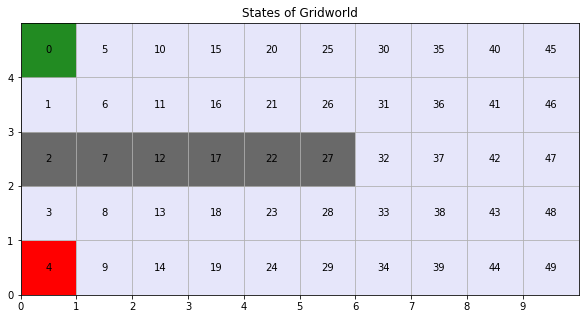

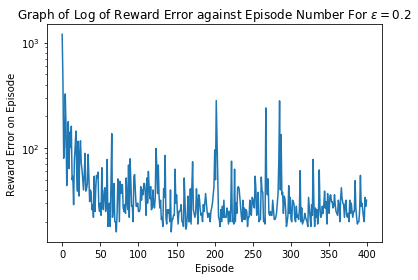

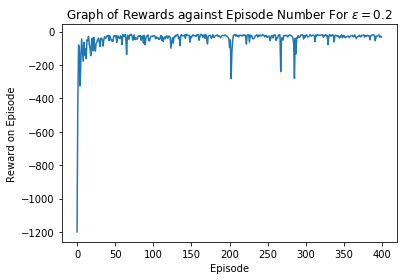

In [22]:
import random
from tqdm import tqdm


def e_greedy(Q, epsilon, s):
    if np.random.rand() > epsilon:
        return np.argmax(Q[s,:])
    else:
        return random.randint(0, len(Q[s,:]) - 1)
    
    
def initialise_Q(s, a):
    return np.ones((s,a))
    #return np.random.random((s,a))
    #return np.zeros((s,a))


def SARSA(world, alpha = 0.4, epsilon = 0.05, episodes = 400, steps = 2500, verbose = True):
    num_states = len(world.states)
    num_actions = len(world.actions)
    Q = initialise_Q(num_states, num_actions)    
    out = []
    c = 0
    
    if verbose:
        run = tqdm(range(episodes))
    else:
        run = range(episodes)
    
    for episode in run:
        s = world.start
        a = e_greedy(Q, epsilon, s)
        t = 0
        reward = 0
        g = False
        
        while t < steps:   

            ns, r =  world.state_action_state(s, a)[0]
            
            ## Experimenting with restricting path
            #while test:
            #    ns, r =  world.state_action_state(s, a)[0]
            #    if ns == s:
            #        Q[s, a] += cliff_penalty
            #        a = e_greedy(Q, epsilon, s)
            #    else:
            #        test = False            
            
            if ns in world.goal:
                g = True
            
            reward += r
            na = e_greedy(Q, epsilon, ns)

            
            if g:
                Q[s, a] += alpha * (r - Q[s, a])
            else:
                Q[s, a] += alpha * (r + (world.gamma * Q[ns, na]) - Q[s, a])
            
            s, a = ns, na
            t += 1
            if g:
                out.append([episode, reward])
                t += steps
                
        if t < steps + 2:
            out.append([episode, reward])
    return out, Q


world3 = GridWorld(10, 5, gamma=0.9, start=[0,0], goal=[0,4], cliff=[[0,2], [1,2], [2,2], [3,2], [4,2], [5,2]],cliff_penalty=-8)
world3.plot_states()

epsilon = 0.2
o, _ = SARSA(world3, epsilon = epsilon)
o = np.array(o)

plt.figure()
plt.plot(o[:,0], -o[:,1])
plt.xlabel("Episode")
plt.ylabel("Reward Error on Episode")
plt.yscale("log")
plt.title(f"Graph of Log of Reward Error against Episode Number For $\epsilon = {epsilon}$")
plt.show()

plt.figure()
plt.plot(o[:,0], o[:,1])
plt.xlabel("Episode")
plt.ylabel("Reward on Episode")
plt.title(f"Graph of Rewards against Episode Number For $\epsilon = {epsilon}$")
plt.show()

#### Plotting Results

Now that the aglorithm has been implemented, it would be useful to display the final path found by the algorithm. Once again using a greedy strategy, the final path is essentially one that follows $\epsilon = 0$, where there is no exploration. These will be used later but are defined in the original `GridWorld` class and tested here.

As can be seen from the example below, the SARSA algorithm performs very well compared to the greedy dynamic programming startegy used previously.

100%|██████████| 2000/2000 [00:00<00:00, 3302.71it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:344: RuntimeWarning: invalid value encountered in double_scalars


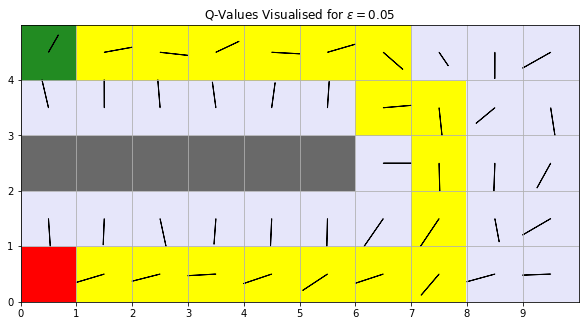

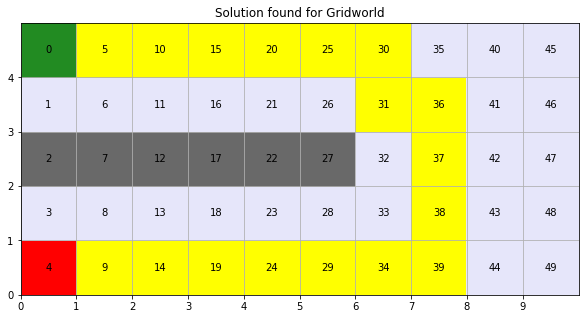

In [14]:
world3 = GridWorld(10, 5, gamma=0.9, start=[0,0], goal=[0,4], cliff=[[0,2], [1,2], [2,2], [3,2], [4,2], [5,2]],cliff_penalty=-10)

epsilon = 0.05
o, q = SARSA(world3, epsilon = epsilon, episodes = 2000)
o = np.array(o)


path = [world3.start]

while not path[-1] in world3.goal:
    path.append(world3.state_action_state(path[-1],np.argmax(q[path[-1],:]))[0][0])

    
world3.plot_Q_function(Q = q, Path = path, title = f"Q-Values Visualised for $\epsilon = {epsilon}$")
world3.plot_solution(path)

### 2.b.

Within the pervious section, while implementing the SARSA algorithm, the total reward against number of episodes was graphed for testing purposes. To extend beyond this, I defined serveral different values for $\epsilon$ to compare against on the plot. As can be seen below, the low values of $\epsilon$ appear to be the best for the SARSA algorithm, restricting the randomisation.

The cube world used for this is one of the complex ones original defined below part 3.

The values displayed for the reward error on each episode are only those in the range $[-200, 0]$ to give better definition on the better results after a few episodes. 

100%|██████████| 5/5 [00:52<00:00, 13.82s/it]


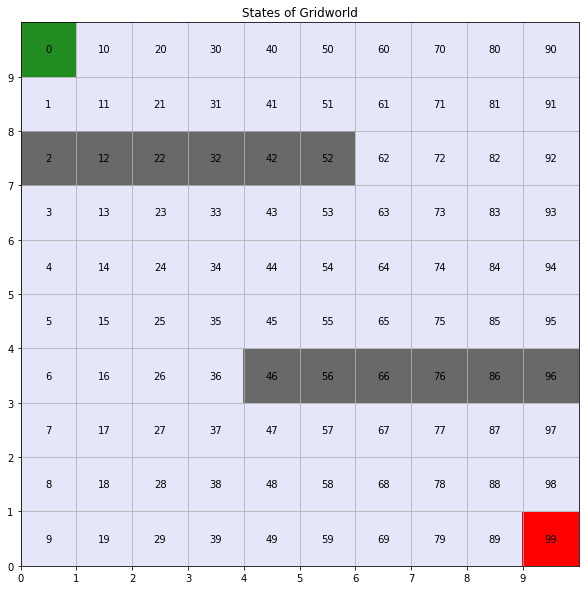

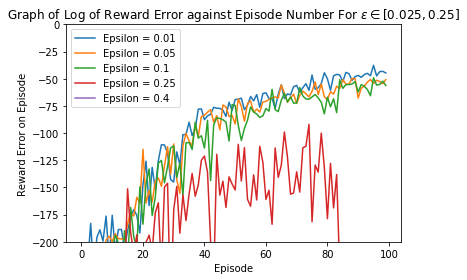

In [11]:
epsilon_range = [0.01,0.05,0.1,0.25,0.40]
episodes = 100
iterations = 25


world1 = GridWorld(10,10, gamma=0.9, start=[0,0], goal=[9,9], cliff=[[0,2], [1,2], [2,2], [3,2], [4,2], [5,2], 
                                                                     [4,6], [5,6], [6,6], [7,6], [8,6], [9,6]])
world1.plot_states()

plt.figure()
for epsilon in tqdm(epsilon_range):
    to = np.zeros((episodes, 2))
    for i in range(iterations):
        o, _ = SARSA(world1, epsilon = epsilon, verbose = False, episodes= episodes)
        o = np.array(o)
        to += o
    to /= iterations
    plt.plot(to[:,0], to[:,1], label=f"Epsilon = {round(epsilon, 2)}")
plt.ylim(-200, 0)
plt.xlabel("Episode")
plt.ylabel("Reward Error on Episode")
plt.title(f"Graph of Log of Reward Error against Episode Number For $\epsilon \in [0.025, 0.25]$")
plt.legend(loc="best")
plt.show()

### 2.c.

For this part we are asked to find the solutions found for different values of $\epsilon$. As seen in the previous part, lower values of $\epsilon$ often return a better value of reward, suggesting the found paths are shorter, hence only smaller values will be used for this part. To find the paths, after all of the episodes are complete at the final values for $Q$ found, the path is found using a greedy strategy. Using the more complex `GridWorld` and $10000$ episodes for each value of $\epsilon$, we get the following results:

Beginning 0.005
Beginning 0.01
Beginning 0.015
Beginning 0.02
Beginning 0.025
Beginning 0.035
Beginning 0.05


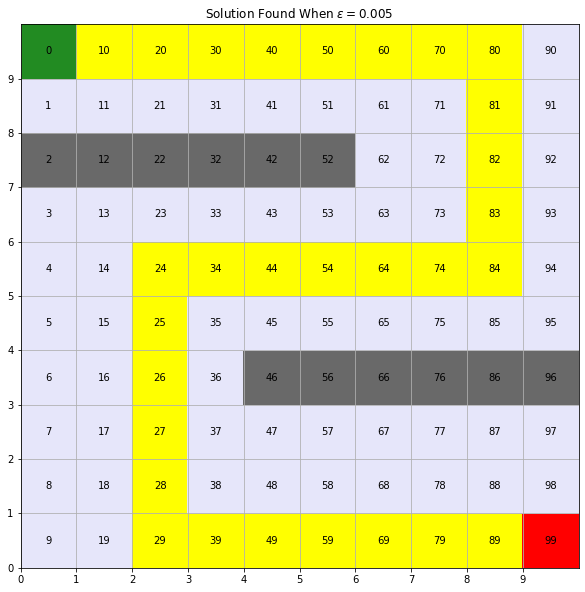

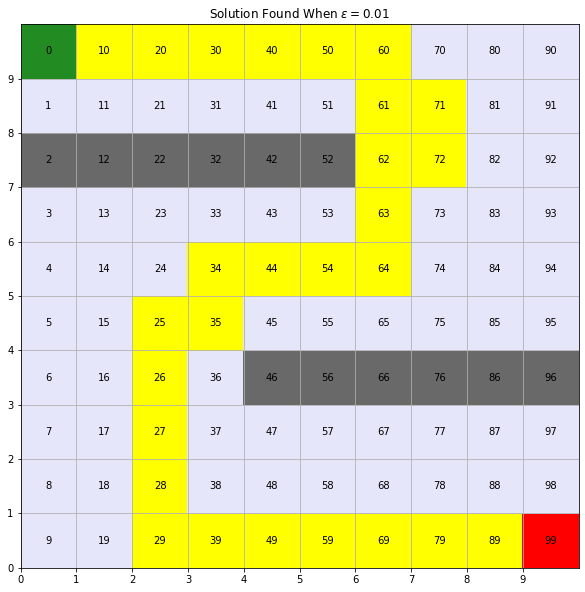

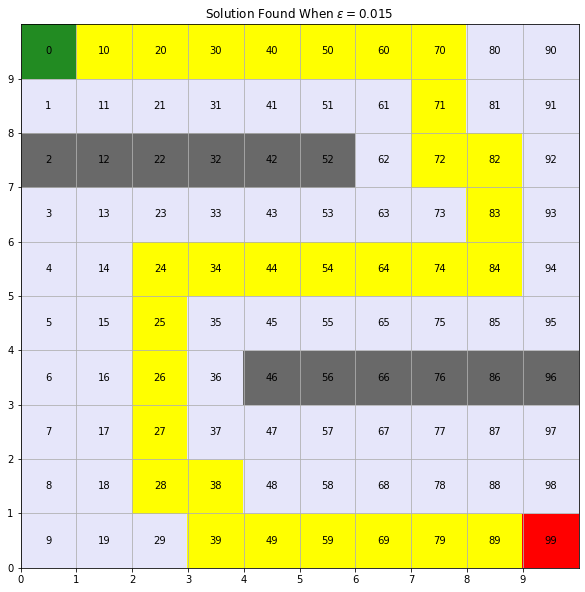

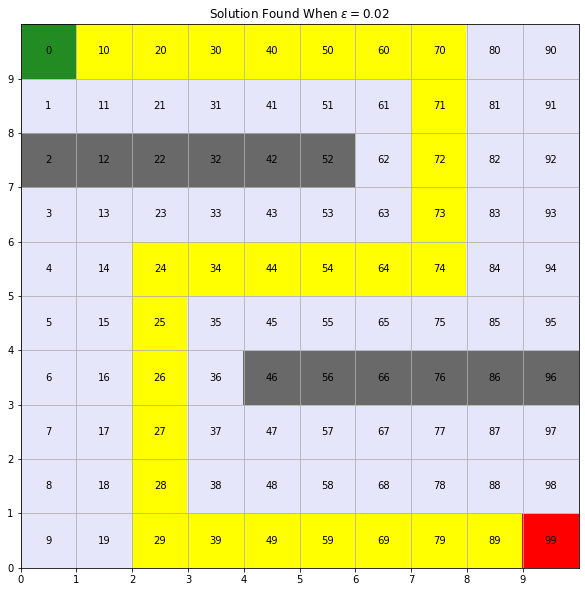

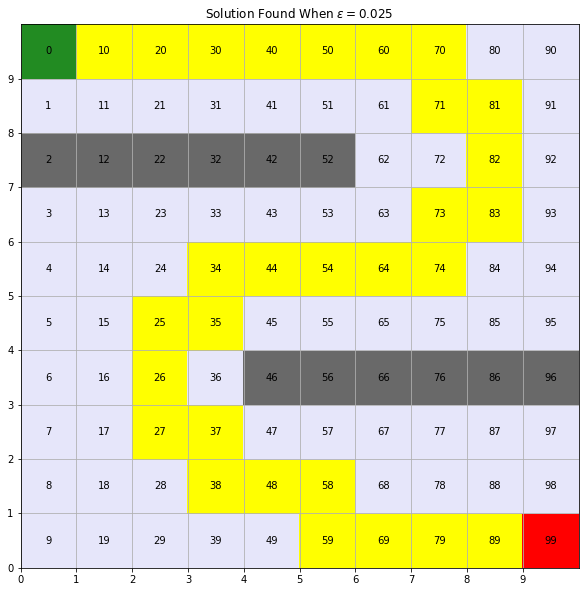

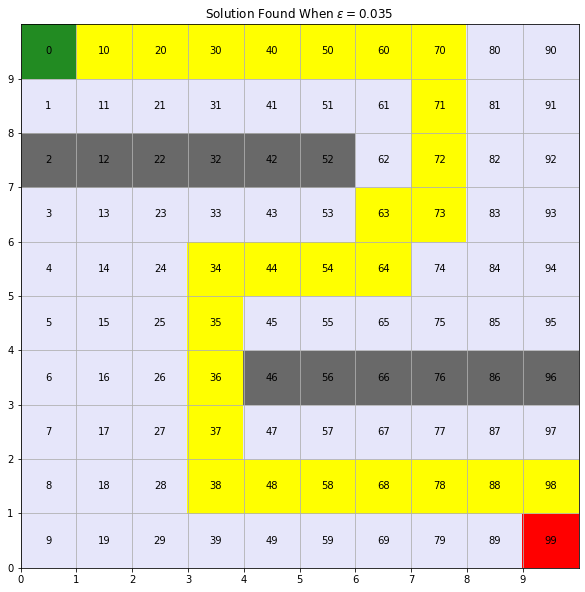

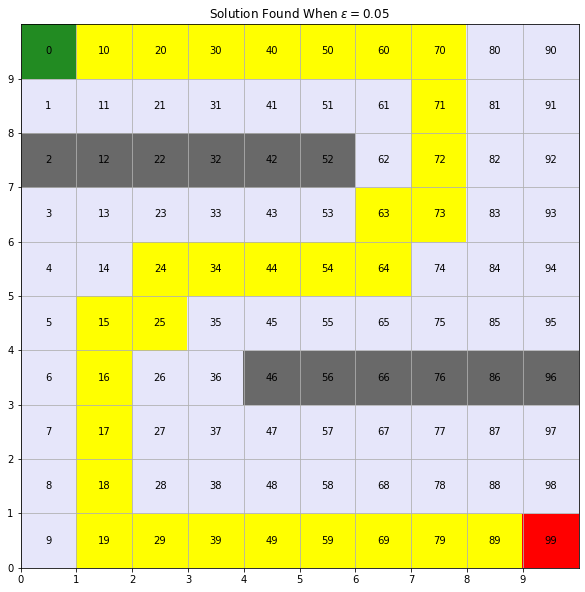

In [17]:
epsilon_range = [0.005, 0.01, 0.015, 0.02, 0.025, 0.035, 0.05]
episodes = 10000


for epsilon in epsilon_range:
    print(f"Beginning {epsilon}")
    world1 = GridWorld(10,10, gamma=0.9, start=[0,0], goal=[9,9], cliff=[[0,2], [1,2], [2,2], [3,2], [4,2], [5,2], 
                                                                     [4,6], [5,6], [6,6], [7,6], [8,6], [9,6]])
    
    _, q = SARSA(world1, epsilon = epsilon, episodes = episodes, verbose = False)

    path = [world1.start]

    while not path[-1] in world1.goal:
        p = world1.state_action_state(path[-1],np.argmax(q[path[-1],:]))[0][0]
        if not p in path:
            path.append(p)
        else:
            break
    
    world1.plot_solution(path, title = f"Solution Found When $\epsilon = {epsilon}$")

The results above continue to show that the lower values for $\epsilon$ are a better choice than the higher, as values $\epsilon \geq 0.5$ would often fail to find a complete "path", getting stuck alternating between two positions in the greedy strategy. It can be seen from this that the limit of SARSA, depends on the policy used to evaluate the different choices, but is fundimentally due to SARSA having stochastic elements, where even using the "best" values of $\epsilon$ still has a chance of getting caught in a loop. The reward graphs consistently have noise, even after several thousand runs.

## 3. Q-learning 
SARSA is called an "on-policy" algorithm, because it makes assumptions on what the action that the policy will make at the next step to estimate $Q$. Therefore, the value function is dependent on the policy! 
$Q$-learning takes an alternative view, so-called "off-policy", where the value of a state-action pair is independent on the policy's actions, and is instead dependent on <i>the best possible course of action thereafter</i>. This is achieved by amending the update function: 
    $$
	Q^{(t+1)}(S_t,A_t)\leftarrow Q^{(t)}(S_t,A_t)+\alpha\left[
	R_{t+1} + \gamma \max_a Q^{(t)}(S_{t+1},a)-Q(S_t,A_t)
	\right]
	$$
    
In this part, you will:

a. implement the off-policy Q-learning algorithm and use it to solve the problem. 
<div style="text-align: right"><b>[10 marks]</b></div>
b. Produce a graph showing the performance of the agent in y-axis and the number of episodes in x-axis. 
<div style="text-align: right"><b>[10 marks]</b></div>
c. Finally, show the solution your algorithm has reached for different values of $\epsilon$.
<div style="text-align: right"><b>[10 marks]</b></div>

### 3.a

#### Q-Learning

Psuedo-code for Q-Learning from the literature is below:

\begin{align*}
\textbf{Input: } \pi& \text{,  policy to be evaluated.} \\
\alpha&\text{, learning rate.} \\
\gamma&\text{, decay rate.} \\
\epsilon&\text{, parameter for exploration.} \\
episodes&\text{, number of iterations to be performed.} \\
steps&\text{, maximum number of steps per episode.}
\\
\textbf{Initialize }& Q(s, a) \forall{s} \in S, a \in A(s)   \\
\textbf{for each episode:}& \\
&\text{Initialize/Reset } S \text{ to start point}  \\
&\textbf{Repeat: } \\
&\qquad \text{Using policy, choose } A \text{ from } S \\ 
&\qquad \text{Take action } A \text{, recording reward, } R \text{, and next position, } S' \\
&\qquad Q(S, A) \leftarrow Q(S,A) + \alpha \left[R + \gamma \cdot max_{a} Q(S',a) - Q(S,A)\right] \\
&\qquad S \leftarrow S' \\
&\qquad A \leftarrow A' \\
&\textbf{until: } \text{Max steps taken} \\
\textbf{return }& Q(s,a)
\end{align*}

The difference with SARSA is seen in when the alogrithm chooses the next action and in how the $Q$ array is updated.

100%|██████████| 400/400 [00:00<00:00, 3508.77it/s]


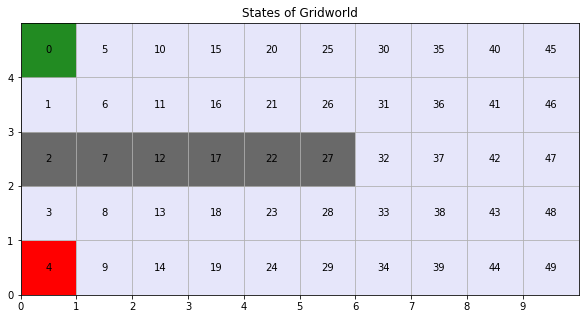

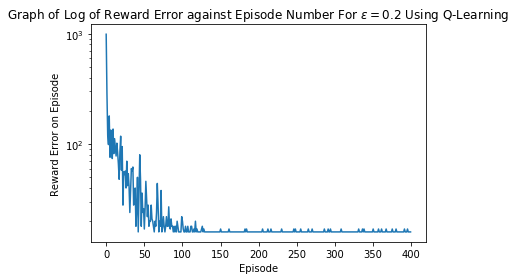

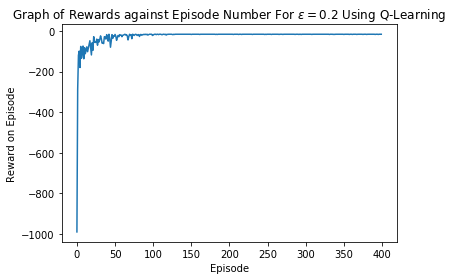

In [39]:
def QLearning(world, alpha = 0.4, epsilon = 0.05, episodes = 400, steps = 2500, verbose = True):
    num_states = len(world.states)
    num_actions = len(world.actions)
    Q = initialise_Q(num_states, num_actions)    
    out = []
    c = 0
    
    if verbose:
        run = tqdm(range(episodes))
    else:
        run = range(episodes)
    
    for episode in run:
        s = world.start
        a = e_greedy(Q, epsilon, s)
        t = 0
        reward = 0
        g = False
        
        while t < steps:   

            ns, r =  world.state_action_state(s, a)[0]                    
            
            if ns in world.goal:
                g = True
            
            reward += r
            na = np.argmax(Q[ns,:])

            
            if g:
                Q[s, a] += alpha * (r - Q[s, a])
            else:
                Q[s, a] += alpha * (r + (world.gamma * Q[ns, na]) - Q[s, a])
            
            s, a = ns, na
            t += 1
            if g:
                out.append([episode, reward])
                t += steps
                
        if t < steps + 2:
            out.append([episode, reward])
    return out, Q


world3 = GridWorld(10, 5, gamma=0.9, start=[0,0], goal=[0,4], cliff=[[0,2], [1,2], [2,2], [3,2], [4,2], [5,2]],cliff_penalty=-8)
world3.plot_states()

epsilon = 0.2
o, _ = QLearning(world3, epsilon = epsilon)
o = np.array(o)

plt.figure()
plt.plot(o[:,0], -o[:,1])
plt.xlabel("Episode")
plt.ylabel("Reward Error on Episode")
plt.yscale("log")
plt.title(f"Graph of Log of Reward Error against Episode Number For $\epsilon = {epsilon}$ Using Q-Learning")
plt.show()

plt.figure()
plt.plot(o[:,0], o[:,1])
plt.xlabel("Episode")
plt.ylabel("Reward on Episode")
plt.title(f"Graph of Rewards against Episode Number For $\epsilon = {epsilon}$ Using Q-Learning")
plt.show()

### 3.b.

For this section, the same test world that was seen in **2.b.** will be used to allow for some basic initial comparisons.

100%|██████████| 5/5 [00:15<00:00,  3.09s/it]


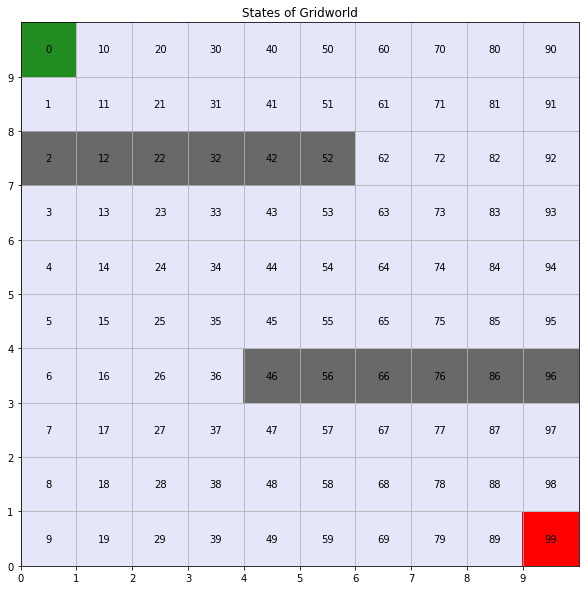

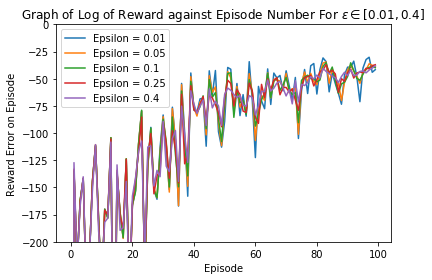

In [27]:
epsilon_range = [0.01,0.05,0.1,0.25,0.40]
episodes = 100
iterations = 25


world1 = GridWorld(10,10, gamma=0.9, start=[0,0], goal=[9,9], cliff=[[0,2], [1,2], [2,2], [3,2], [4,2], [5,2], 
                                                                     [4,6], [5,6], [6,6], [7,6], [8,6], [9,6]])
world1.plot_states()

plt.figure()
for epsilon in tqdm(epsilon_range):
    to = np.zeros((episodes, 2))
    for i in range(iterations):
        o, _ = QLearning(world1, epsilon = epsilon, verbose = False, episodes= episodes)
        o = np.array(o)
        to += o
    to /= iterations
    plt.plot(to[:,0], to[:,1], label=f"Epsilon = {round(epsilon, 2)}")
plt.ylim(-200, 0)
plt.xlabel("Episode")
plt.ylabel("Reward Error on Episode")
plt.title(f"Graph of Log of Reward against Episode Number For $\epsilon \in [0.01, 0.4]$")
plt.legend(loc="best")
plt.show()

As can be seen from the graph above, $Q$-Learning appears less suseptible to changing $\epsilon$. Each value follows the same progression, with the higher values of $\epsilon$ appearing less noisy, despite the decrease in actual randomness. In terms of usefullness, having the algorithm less reliant on a hyper-parameter means that $Q$-Learning can act as a more "universal" algorithm, being less problem specific. This is also apparent when running for greater number of episodes.

As is shown below, $Q$-Learning appears to converge to a reward value, however SARSA continues to have noise for however many episodes are performed. This difference between the two presents $Q$-Learning favourably.

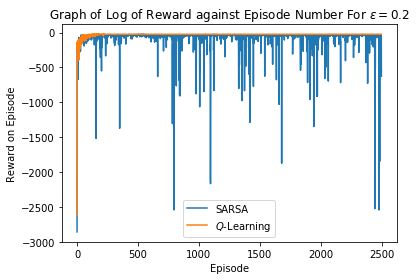

In [49]:
epsilon =  0.1
episodes = 2500


world1 = GridWorld(10,10, gamma=0.9, start=[0,0], goal=[9,9], cliff=[[0,2], [1,2], [2,2], [3,2], [4,2], [5,2], 
                                                                     [4,6], [5,6], [6,6], [7,6], [8,6], [9,6]])

plt.figure()

o, _ = SARSA(world1, epsilon = epsilon, verbose = False, episodes= episodes)
o = np.array(o)
plt.plot(o[:,0],o[:,1], label=f"SARSA")
o, _ = QLearning(world1, epsilon = epsilon, verbose = False, episodes= episodes)
o = np.array(o)
plt.plot(o[:,0],o[:,1], label=f"$Q$-Learning")
#plt.ylim(-400, 0)
plt.xlabel("Episode")
plt.ylabel("Reward on Episode")
plt.title(f"Graph of Log of Reward against Episode Number For $\epsilon = 0.2$")
plt.legend(loc="best")
plt.show()

### 3.c.

Using the same process as in **2.c.**, however as discussed in the previous section, the $Q$-Learning algorithm has less "noise" and as such using a larger range of values for $\epsilon$ is viable, and less episodes need to be performed to achieve a consistent result, however, for comparison later, the same `GridWorld` will be used.

Beginning 0.005
Beginning 0.01
Beginning 0.025
Beginning 0.05
Beginning 0.1
Beginning 0.2


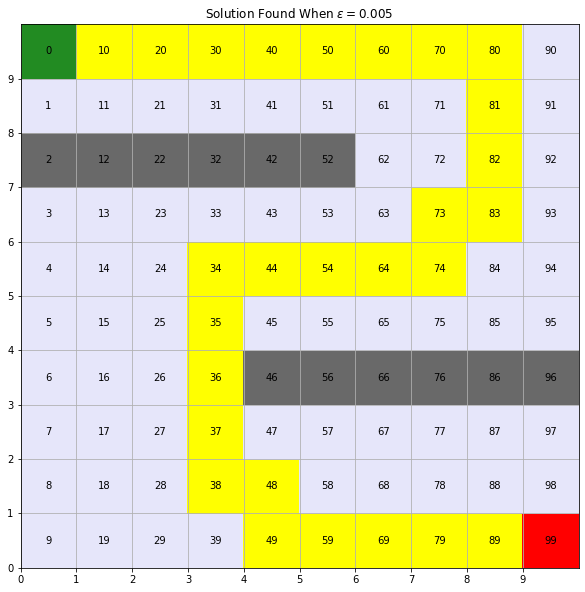

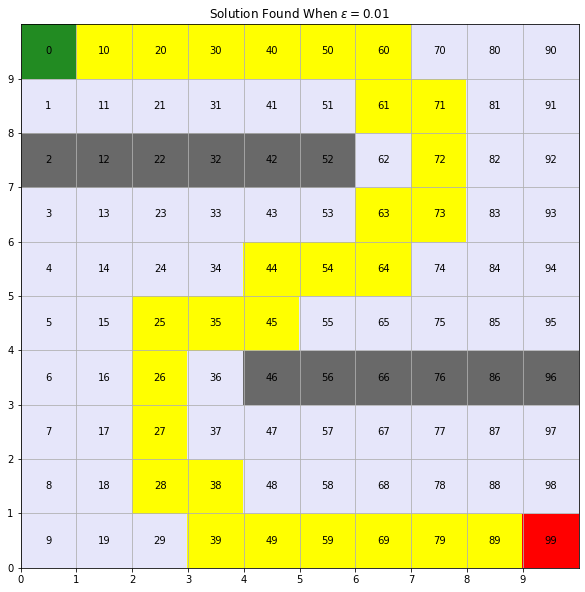

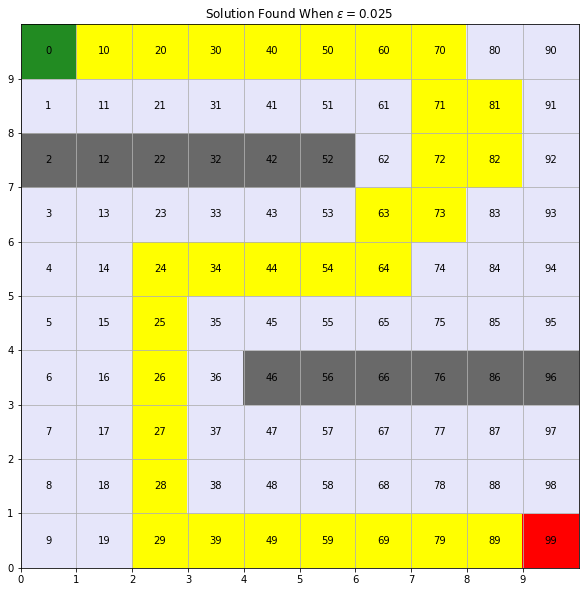

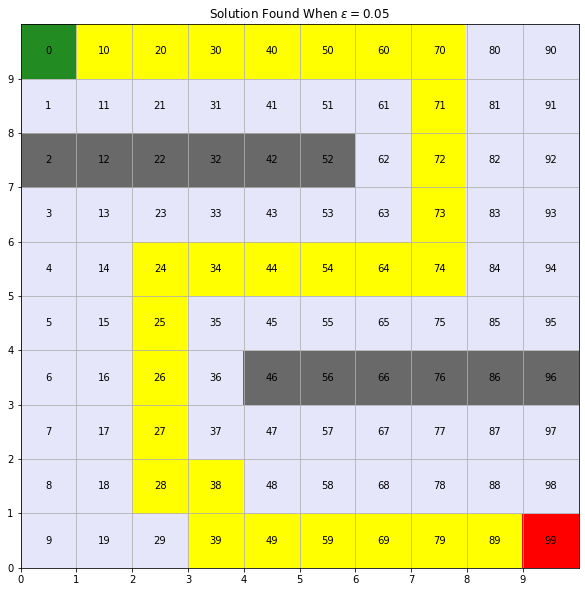

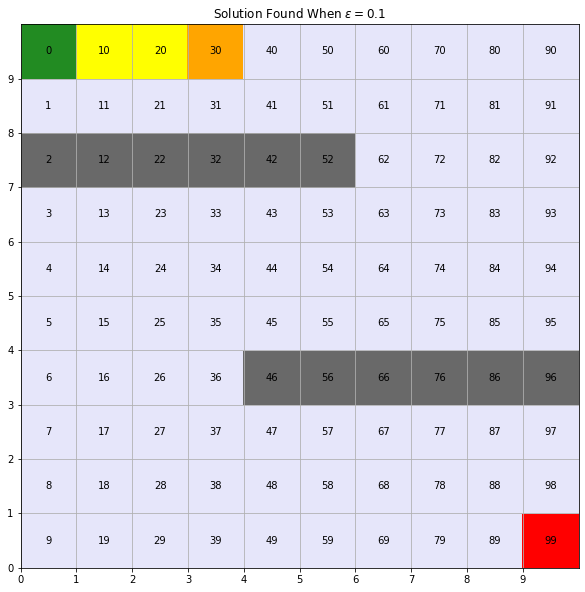

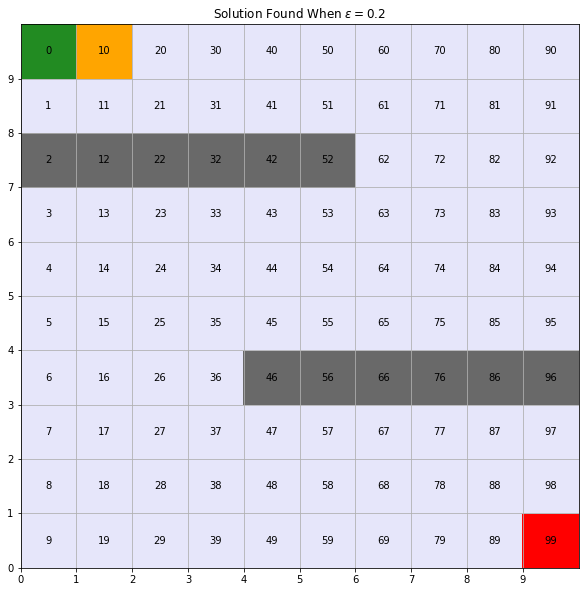

In [53]:
epsilon_range = [0.005, 0.01, 0.025, 0.05, 0.1, 0.2]
episodes = 5000


for epsilon in epsilon_range:
    print(f"Beginning {epsilon}")
    world1 = GridWorld(10,10, gamma=0.9, start=[0,0], goal=[9,9], cliff=[[0,2], [1,2], [2,2], [3,2], [4,2], [5,2], 
                                                                     [4,6], [5,6], [6,6], [7,6], [8,6], [9,6]])
    
    _, q = SARSA(world1, epsilon = epsilon, episodes = episodes, verbose = False)

    path = [world1.start]

    while not path[-1] in world1.goal:
        p = world1.state_action_state(path[-1],np.argmax(q[path[-1],:]))[0][0]
        if not p in path:
            path.append(p)
        else:
            break
    
    world1.plot_solution(path, title = f"Solution Found When $\epsilon = {epsilon}$")

Finally, compare the two algorithms on a number of gridworld configurations (see examples below, but generate a few of your own) and discuss the results. 
<div style="text-align: right"><b>[10 marks]</b></div>

In [38]:
world_zigzag = GridWorld(10,10, gamma=0.9, start=[0,0], goal=[9,9], cliff=[[0,2], [1,2], [2,2], [3,2], [4,2], [5,2], 
                                                                     [4,6], [5,6], [6,6], [7,6], [8,6], [9,6]])
print(world_zigzag.tostring())

cliff = [ [i,j] for i in range(3,7) for j in range(3,7) ]
       
world_sinkhole = GridWorld(10,10, gamma=0.9, start=[9,0], goal=[0,9], cliff=cliff)
print(world_sinkhole.tostring())

world_coridoor = GridWorld(5, 20, gamma = 0.8, start = [2,0], goal=[2,19])
print(world_coridoor.tostring())

world_lesser = GridWorld(7, 5, start = [0,0], goal = [[6,4]], cliff=[[0,2],[1,2],[2,2],[3,2],[4,2],[5,2],[6,2],[0,3],
                                                                [1,3],[2,3],[4,3],[5,3],[6,3]])
print(world_lesser.tostring())

world_spiral = GridWorld(11,11, gamma=0.9, start=[0,0], goal=[4,6], cliff=[ [0,1], [1,1], [2,1], [3,1], [4,1], [5,1], 
                                                                     [6,1], [7,1], [8,1], [9,1], [9,2],
                                                                     [9,3], [9,4], [9,5], [9,6], [9,7], [9,8],
                                                                     [9,9], [8,9], [7,9], [6,9], [5,9], [4,9], [3,9],
                                                                     [2,9], [1,9], [1,8], [1,7], [1,6], [1,5], [1,4], [1,3],
                                                                     [2,3], [3,3], [4,3], [5,3], [6,3], [7,3],
                                                                     [7,4], [7,5], [7,6], [7,7], [6,7], [5,7],
                                                                     [4,7], [3,7], [3,6], [3,5], [4,5], [5,5]])
print(world_spiral.tostring())

Grid world:
+-+-+-+-+-+-+-+-+-+-+
|S| | | | | | | | | |
+-+-+-+-+-+-+-+-+-+-+
| | | | | | | | | | |
+-+-+-+-+-+-+-+-+-+-+
|X|X|X|X|X|X| | | | |
+-+-+-+-+-+-+-+-+-+-+
| | | | | | | | | | |
+-+-+-+-+-+-+-+-+-+-+
| | | | | | | | | | |
+-+-+-+-+-+-+-+-+-+-+
| | | | | | | | | | |
+-+-+-+-+-+-+-+-+-+-+
| | | | |X|X|X|X|X|X|
+-+-+-+-+-+-+-+-+-+-+
| | | | | | | | | | |
+-+-+-+-+-+-+-+-+-+-+
| | | | | | | | | | |
+-+-+-+-+-+-+-+-+-+-+
| | | | | | | | | |G|
+-+-+-+-+-+-+-+-+-+-+

Grid world:
+-+-+-+-+-+-+-+-+-+-+
| | | | | | | | | |S|
+-+-+-+-+-+-+-+-+-+-+
| | | | | | | | | | |
+-+-+-+-+-+-+-+-+-+-+
| | | | | | | | | | |
+-+-+-+-+-+-+-+-+-+-+
| | | |X|X|X|X| | | |
+-+-+-+-+-+-+-+-+-+-+
| | | |X|X|X|X| | | |
+-+-+-+-+-+-+-+-+-+-+
| | | |X|X|X|X| | | |
+-+-+-+-+-+-+-+-+-+-+
| | | |X|X|X|X| | | |
+-+-+-+-+-+-+-+-+-+-+
| | | | | | | | | | |
+-+-+-+-+-+-+-+-+-+-+
| | | | | | | | | | |
+-+-+-+-+-+-+-+-+-+-+
|G| | | | | | | | | |
+-+-+-+-+-+-+-+-+-+-+

Grid world:
+-+-+-+-+-+
| | |S| | |
+-+-+-+-+-+
| 

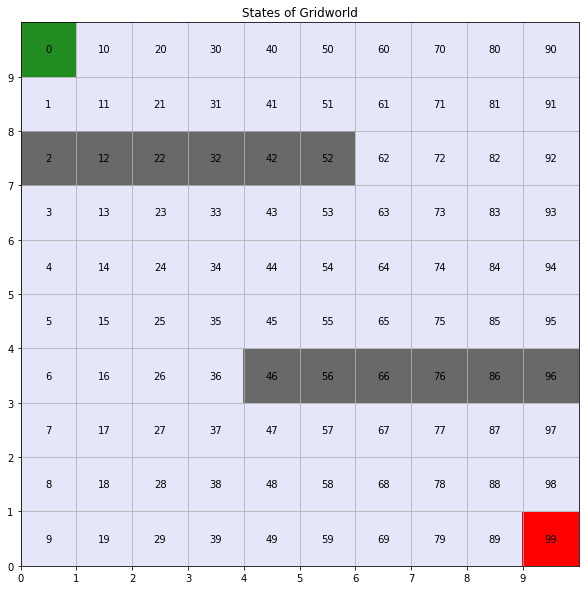

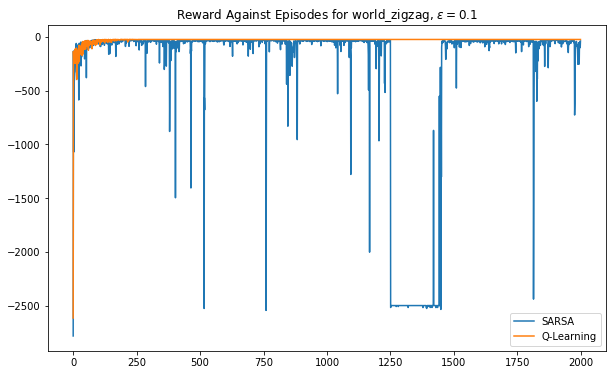

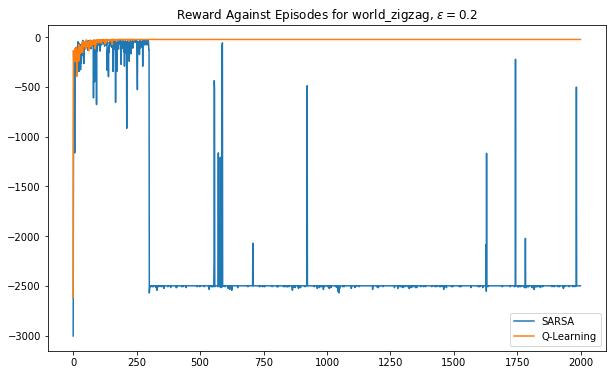

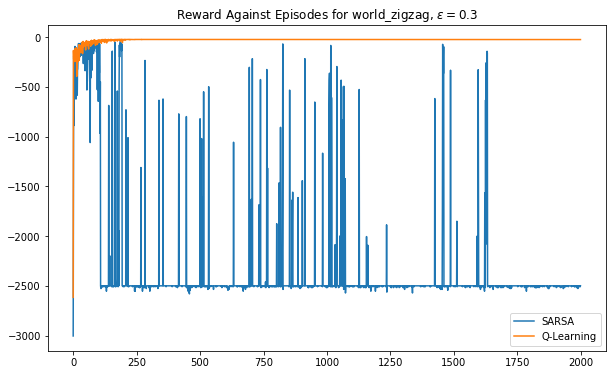

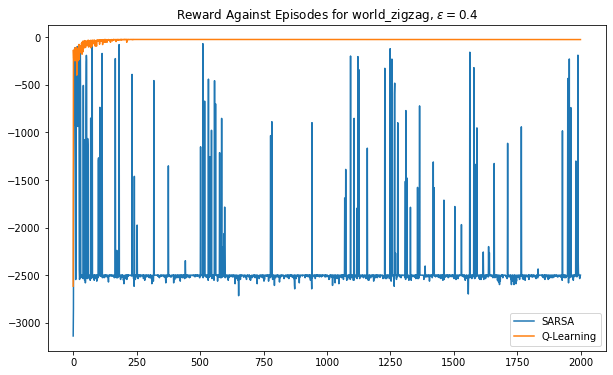

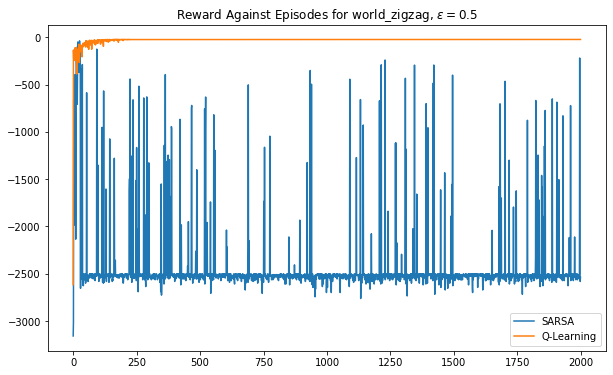

In [79]:
episodes = 2000
world = world_zigzag

world.plot_states()

epsilon_range = [0.1,0.2,0.3,0.4, 0.5]

for epsilon in epsilon_range:
  sarsa, _ = SARSA(world, epsilon = epsilon, verbose=False, episodes = episodes)
  qlearning, _ = QLearning(world, epsilon = epsilon, verbose=False, episodes = episodes)

  sarsa = np.array(sarsa)
  qlearning = np.array(qlearning)

  plt.figure(figsize=((10,6)))
  plt.plot(sarsa[:,0],sarsa[:,1], label="SARSA")
  plt.plot(qlearning[:,0],qlearning[:,1], label="Q-Learning")
  plt.title(f"Reward Against Episodes for world_zigzag, $\epsilon = {epsilon}$")
  plt.legend(loc="best")

For this first set of trials, it appears that SARSA initially finds a path close to the optimum, but then becomes quickly worse. It's clearly worse than $Q$-Learning for this example. 

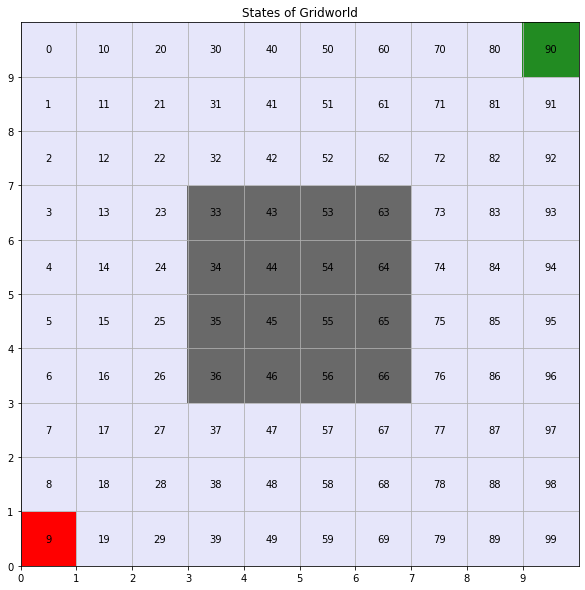

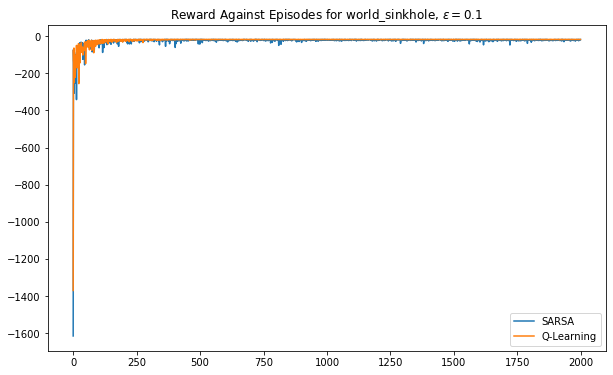

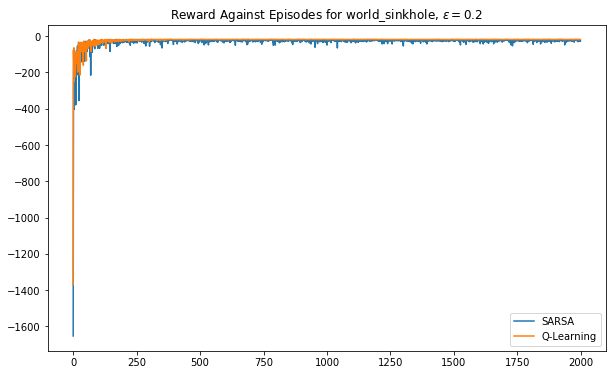

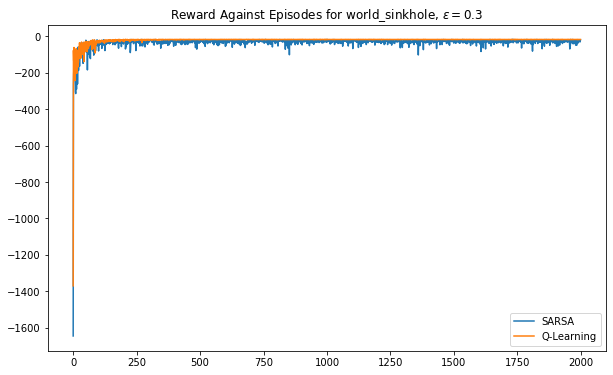

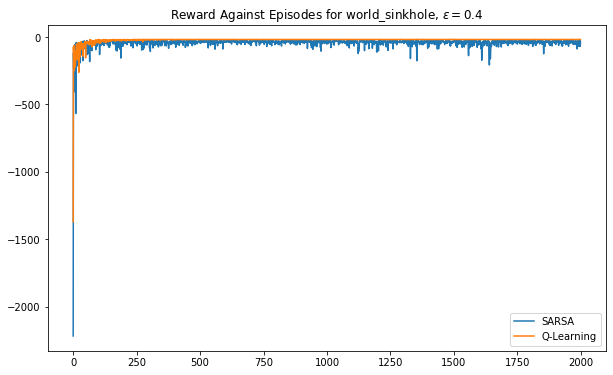

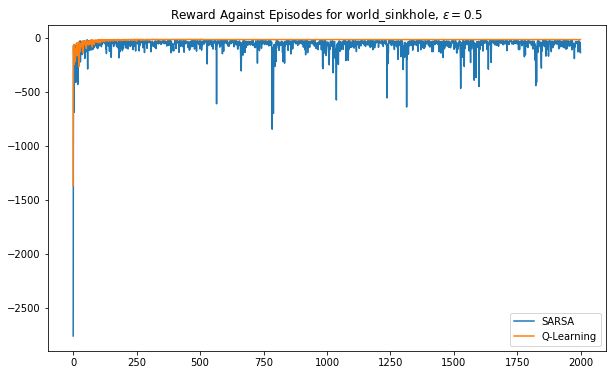

In [76]:
episodes = 2000
world = world_sinkhole

world.plot_states()

epsilon_range = [0.1,0.2,0.3,0.4, 0.5]

for epsilon in epsilon_range:
  sarsa, _ = SARSA(world, epsilon = epsilon, verbose=False, episodes = episodes)
  qlearning, _ = QLearning(world, epsilon = epsilon, verbose=False, episodes = episodes)

  sarsa = np.array(sarsa)
  qlearning = np.array(qlearning)

  plt.figure(figsize=((10,6)))
  plt.plot(sarsa[:,0],sarsa[:,1], label="SARSA")
  plt.plot(qlearning[:,0],qlearning[:,1], label="Q-Learning")
  plt.title(f"Reward Against Episodes for world_sinkhole, $\epsilon = {epsilon}$")
  plt.legend(loc="best")

For each trial of this `CubeWorld` problem, both SARSA and $Q$-Learning quickly converge to the optimum, this leaves the only difference to be the noise that remains present in the SARSA results, which increases in proportion to $\epsilon$. 

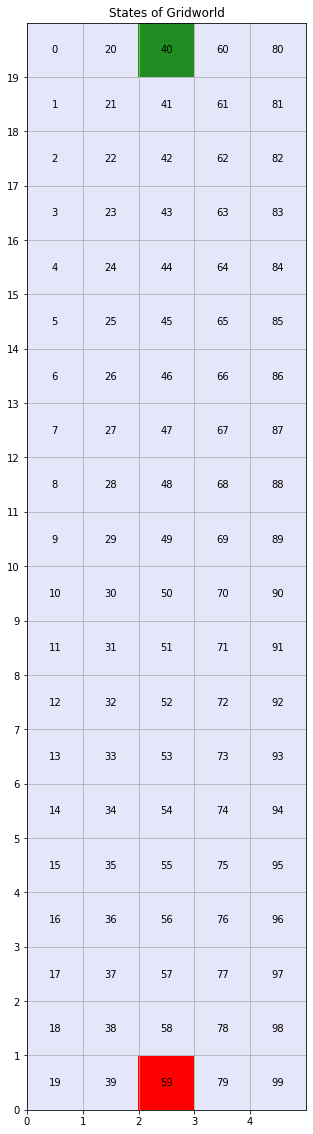

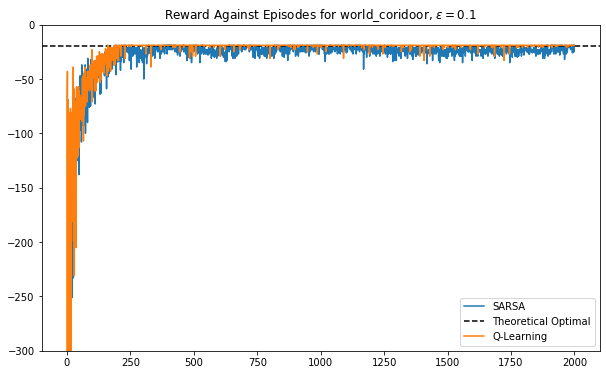

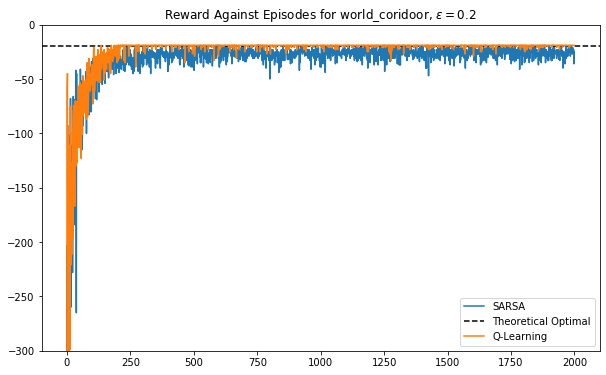

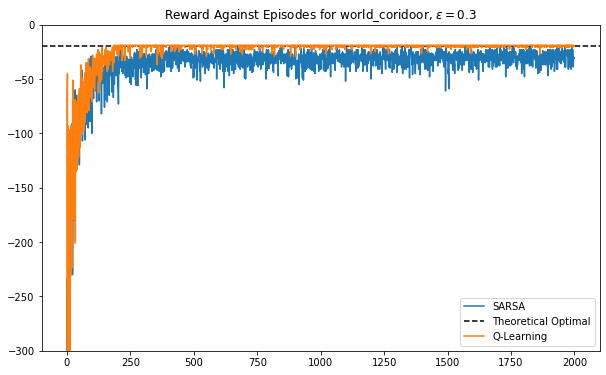

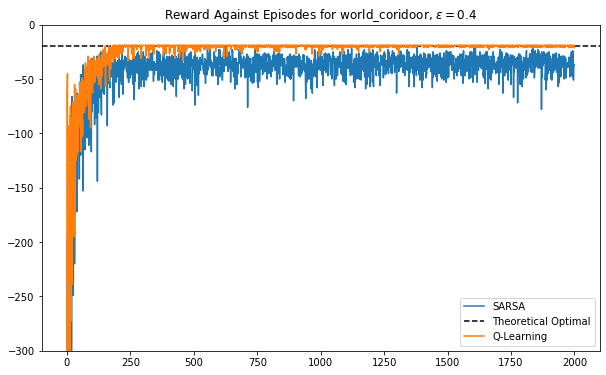

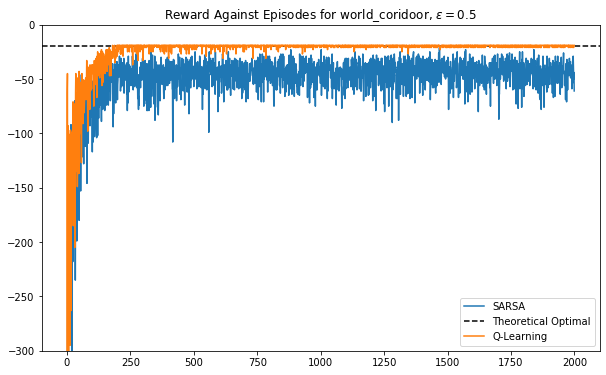

In [88]:
episodes = 2000
world = world_coridoor

world.plot_states()

epsilon_range = [0.1,0.2,0.3,0.4, 0.5]

for epsilon in epsilon_range:
  sarsa, _ = SARSA(world, epsilon = epsilon, verbose=False, episodes = episodes)
  qlearning, _ = QLearning(world, epsilon = epsilon, verbose=False, episodes = episodes)

  sarsa = np.array(sarsa)
  qlearning = np.array(qlearning)

  # plt.figure(figsize=((10,6)))
  # plt.plot(sarsa[:,0],sarsa[:,1], label="SARSA")
  # plt.plot(qlearning[:,0],qlearning[:,1], label="Q-Learning")
  # plt.title(f"Reward Against Episodes for world_coridoor, $\epsilon = {epsilon}$")
  # plt.legend(loc="best")

  plt.figure(figsize=((10,6)))
  plt.plot(sarsa[:,0],sarsa[:,1], label="SARSA")
  plt.ylim((-300,0))
  plt.axhline(y=-20,label="Theoretical Optimal", linestyle="--",c="k")
  plt.plot(qlearning[:,0],qlearning[:,1], label="Q-Learning")
  plt.title(f"Reward Against Episodes for world_coridoor, $\epsilon = {epsilon}$")
  plt.legend(loc="best")

For this set of trials, the `CudeWorld` is set to a simple coridoor, where the ideal path is to go straight down continuously for an optimal reward of $-20$. $Q$-Learning converges to this in each trial in $\approx 250$ episodes. SARSA in comparison, for lower values of $\epsilon$, also appears to reach this optimal value, however has far larger amounts of noise, not remaining close to this value as $Q$-Learning does. At higher values of $\epsilon$, SARSA fails to approach this optimal value and continues to increase in noise.


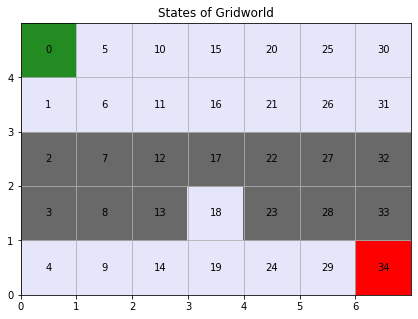

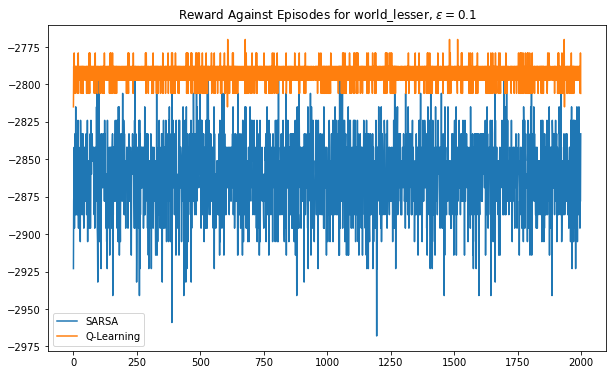

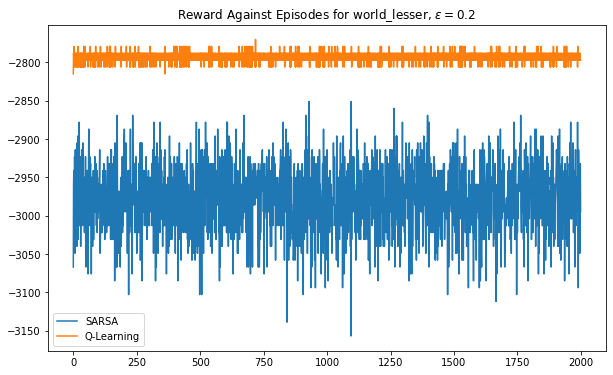

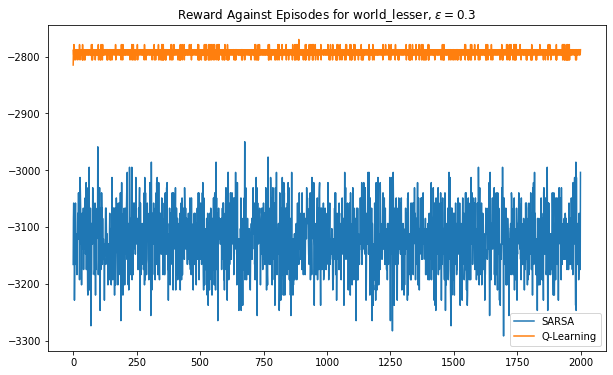

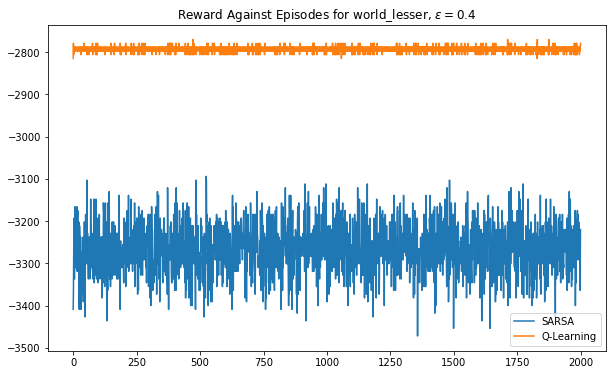

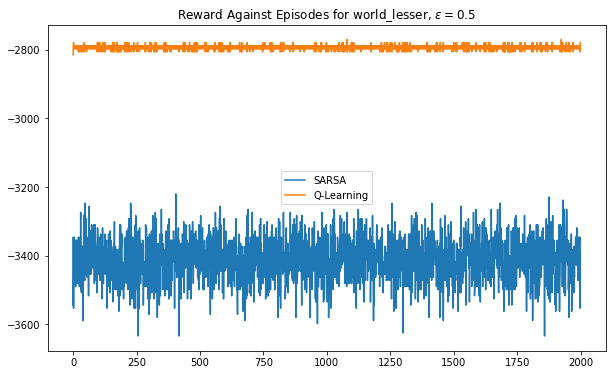

In [80]:
episodes = 2000
world = world_lesser

world.plot_states()

epsilon_range = [0.1,0.2,0.3,0.4, 0.5]

for epsilon in epsilon_range:
  sarsa, _ = SARSA(world, epsilon = epsilon, verbose=False, episodes = episodes)
  qlearning, _ = QLearning(world, epsilon = epsilon, verbose=False, episodes = episodes)

  sarsa = np.array(sarsa)
  qlearning = np.array(qlearning)

  plt.figure(figsize=((10,6)))
  plt.plot(sarsa[:,0],sarsa[:,1], label="SARSA")
  plt.plot(qlearning[:,0],qlearning[:,1], label="Q-Learning")
  plt.title(f"Reward Against Episodes for world_lesser, $\epsilon = {epsilon}$")
  plt.legend(loc="best")

In these trials I tested to see what would happen if the `CubeWorld` required the algorithm to pass through a "cliff" to reach the goal. In this case the optimal reward is approximately $-20$. As can be seen the two algorithms are far from finding this minimal penalty, however this is still a clear difference between the two. Once again it is seen that $Q$-Learning is far less susceptible to changes in $\epsilon$. For each value of $\epsilon$, $Q$-Learning finds an "best" reward of $\approx -2800$, however for SARSA the "best" reward is, at best, $\approx -2850$ for the lowest value of $\epsilon$, slightly worse than $Q$-Learning.

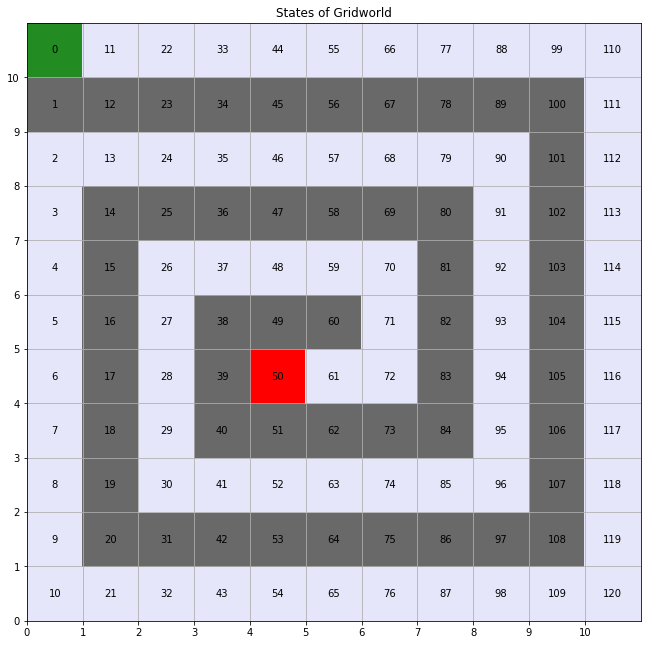

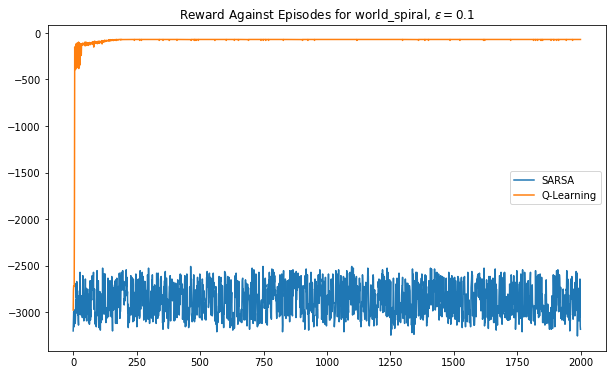

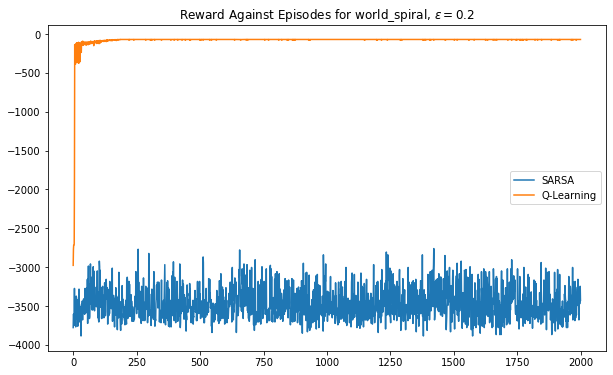

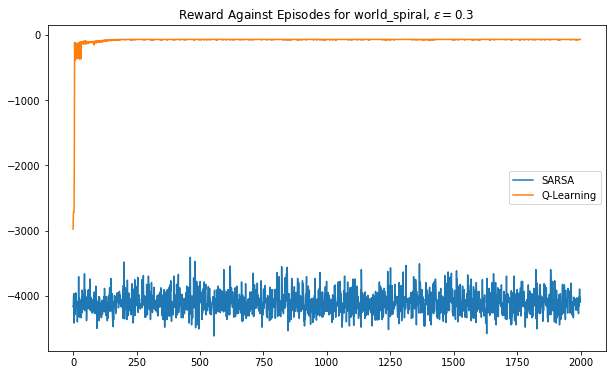

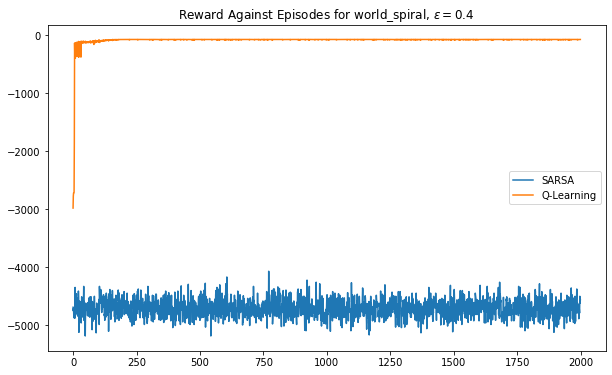

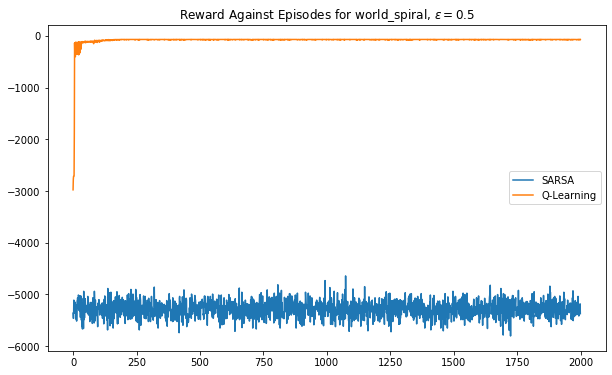

In [78]:
episodes = 2000
world = world_spiral

world.plot_states()

epsilon_range = [0.1,0.2,0.3,0.4, 0.5]

for epsilon in epsilon_range:
  sarsa, _ = SARSA(world, epsilon = epsilon, verbose=False, episodes = episodes)
  qlearning, _ = QLearning(world, epsilon = epsilon, verbose=False, episodes = episodes)

  sarsa = np.array(sarsa)
  qlearning = np.array(qlearning)

  plt.figure(figsize=((10,6)))
  plt.plot(sarsa[:,0],sarsa[:,1], label="SARSA")
  plt.plot(qlearning[:,0],qlearning[:,1], label="Q-Learning")
  plt.title(f"Reward Against Episodes for world_spiral, $\epsilon = {epsilon}$")
  plt.legend(loc="best")

For this `GridWorld` where the optimal path is a spiral, a large difference between the two algorithms can be seen. While the differences between values of $\epsilon$ still remain (reward $\approx -3000$ for $\epsilon = 0.1$, reward $\approx -5000$ for $\epsilon = 0.5$,), it's obvious to see that no matter the value for $\epsilon$, SARSA fails to find the correct path, unlike $Q$-Learning which, for each value of $\epsilon$ converges to a "good" path very quickly for each trial.

#### Overall

Consitently through the trials of `CubeWorld` SARSA has performed worse when looking for the optimal reward after a short series of episodes, and this style of problem it is clear that $Q$-Learning holds the advantage, where our goal is to find the optimal in a short simulation as this is the goal of the algorithm. For SARSA, where there is a greater emphasis on exploration, finding the optimal would require a different policy or an $\epsilon$-decay startegy to find the optimal more consistently. For more complex problems that aren't possible in this basic `CubeWorld`, $Q$-Learning's quick convergence may not be as desirable, and in the cases where one aims to avoid risk from possibly selecting a dangerous action, SARSA may be more desirable.